In [1]:
%matplotlib inline
import MDAnalysis as mda
import numpy as np
import pytim
from pytim.datafiles import WATER_GRO,WATER_XTC
import matplotlib as mpl
mpl.rcParams['figure.dpi']=120

Let's build an observable that computes both angles for a bivariate distrubution of orientations.
This will be used to compute the distributions for atoms in the first and second layers

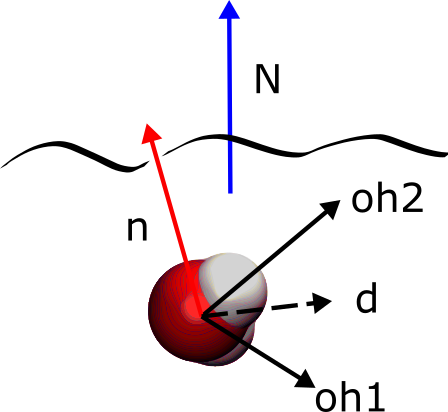

The two angles are $\theta$ and $\phi$. 
The angle $\theta$ is defined through $N\cdot{}d = \cos\theta$, where $N$ is the unit surface normal and $d$ is the unit vector in the direction of the water dipole. The molecular plane normal is denoted as $n$.
The angle $\phi$ is defined as the angle between the projection of $N$ onto the plane defined by $d$ and $n$.

In [2]:
from pytim.observables import Observable

# Now this observable is in the pytim package! 

class BivariateAngles(Observable):
    def __init__(self,u,molecular=False):
        options=['']
        if molecular: options=['molecular']
        self.molecular_plane_vector  = pytim.observables.Orientation(u,options=options+['normal'])
        self.dipole_vector = pytim.observables.Orientation(u,options=options)
    def compute(self, inp,**kargs):
        v_normal = self.molecular_plane_vector.compute(inp)
        v_dipole = self.dipole_vector.compute(inp)
        try:
            v_surface = np.asarray(kargs['normal'])
        except:
            try:
                v_surface = u.inter.normal
            except:
                v_surface = np.asarray([0.,0.,1.])

        costheta = np.dot(v_dipole, v_surface)                
        # the surface normal projected on the plane with normal v_dipole
        v = (v_surface-v_dipole*costheta[:,np.newaxis])
        v = v / np.linalg.norm(v,axis=1)[:,np.newaxis]
        normal_component = np.sum(v*v_normal,axis=1)
        # avoid numerical errors
        normal_component[normal_component>1.0]=1.0
        normal_component[normal_component<-1.0]=-1.0
        orthogonal_component = np.sqrt(1-normal_component**2)
        phi = np.mod(np.arctan2(normal_component, orthogonal_component),np.pi/2)
        return costheta,phi

Let's load a trajectory shipped with pytim for testing, and set up pytim too identify 2 layers using the ITIM algorithm

In [3]:
u = mda.Universe(WATER_GRO, WATER_XTC)
o = u.atoms.select_atoms('name OW')
h = u.atoms[u.atoms.names!='OW']
inter = pytim.ITIM(o,alpha=2.0,cluster_cut=3.5,molecular=True,max_layers=2)

Now we need to compute both angles, using the correct surface normal for each side. We add the series of the angle $\phi$ and of $\cos(\theta)$ to a simple dictionary

In [4]:
biv = BivariateAngles(u,molecular=True)
costheta, phi = {'L1':[],'L2':[]},{'L1':[],'L2':[]} 

for ts in u.trajectory[:100]:
    
    # we need to distinguish the two sides
    for side in [0,1]:
        normal = [0,0,1.]
        if side == 1: normal = [0,0,-1.]
        # the property 'sides' of AtomGroup set by ITIM is handy
        # to select atoms in the first layer of each of the sides
        for layer in [1,2]:
            condition = np.logical_and(u.atoms.sides==side,u.atoms.layers==layer)
            group = u.atoms[condition]
            c,p  =  biv.compute(group,normal=normal)
            costheta['L'+str(layer)]+=list(c)
            phi['L'+str(layer)]+=list(p)

Let's make a quick 2d histogram to see if everything is fine, we collect also the maxiumum value

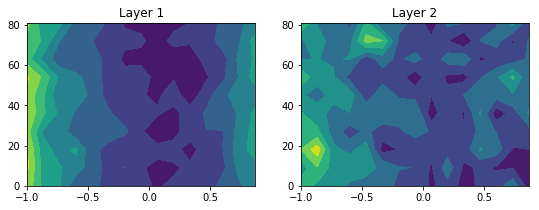

In [5]:
from matplotlib import pyplot as plt
import scipy.ndimage 
from matplotlib.ticker import FuncFormatter, MultipleLocator

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9,3))
maxval=0
for n,ax in enumerate(axes.flat):
    layer=n+1
    ID='L'+str(layer)
    # let's plot the histogram to check that everything went fine (color scales are different!)
    h,th,ph =np.histogram2d(costheta[ID],phi[ID],bins=[15,10],normed=True)
    # the free energy from P = exp(-U/kT) 
    h = -np.log(h)
    maxval = max(maxval,np.max(h))

    contour = ax.contourf(th[:-1],ph[:-1]*180/np.pi,h.T-np.min(h))
    ax.set_title("Layer "+str(layer))

plt.show()


And finally we make a nice plot of the 1st and second layer free energy landscape 

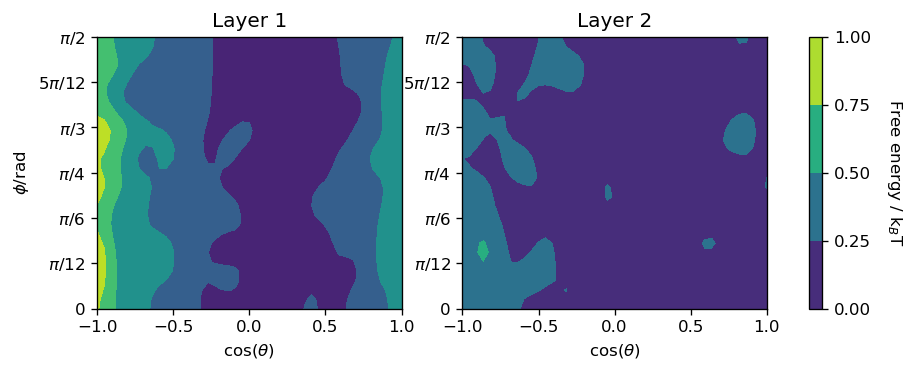

In [8]:
# Now we make it prettier with 3rd order polynomial interpolation
# and ticks in multiple os Pi (see formatter below, cell to be loaded before this)
mpl.rcParams['figure.dpi']=120

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(9,3))
major = Multiple(12, np.pi, r'\pi')

for n,ax in enumerate(axes.flat):
    layer=n+1
    ID='L'+str(layer)
    h,th,ph =np.histogram2d(costheta[ID],phi[ID],bins=[15,10],normed=True)
    h = -np.log(h)
    h2  = scipy.ndimage.zoom(h, 3)
    th2 = np.linspace(th[0],th[-1],h2.shape[0])
    ph2 = np.linspace(ph[0],ph[-1],h2.shape[1])
    contour = ax.contourf(th2,ph2,h2.T-np.min(h2),
                          levels=np.arange(0.,maxval-np.min(h2)+0.25,0.25))

    ax.set_title("Layer "+str(layer))
    ax.yaxis.set_major_locator(MultipleLocator(base=np.pi/4))
    ax.yaxis.set_major_locator(major.locator())
    ax.yaxis.set_major_formatter(major.formatter())
    
    ax.set_xlabel('$\\cos(\\theta)$')
    if n==0: ax.set_ylabel('$\\phi$/rad')

cbar=fig.colorbar(contour,ax=axes.ravel().tolist())
cbar.set_label('Free energy / k$_B$T', rotation=270,labelpad=20)

plt.show()



In [7]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    """ Thanks to Scott Centoni
        https://stackoverflow.com/questions/40642061/how-to-set-axis-ticks-in-multiples-of-pi-python-matplotlib
    """
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'${%s}/{%s}$'%(latex,den)
            elif num==-1:
                return r'${-%s}/{%s}$'%(latex,den)
            else:
                return r'${%s%s}/{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex

    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)

    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))